In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
!pip install scipy

In [3]:
from scipy.spatial.transform import Rotation

In [4]:
def positional_encoding(x, num_frequencies=6, incl_input=True):


    results = []
    if incl_input:
        results.append(x)

    freq = torch.pow(2,torch.arange(num_frequencies)).to(device)
    sin_list = torch.sin(torch.pi*freq*x.reshape((-1,1))).to(device)
    cos_list  = torch.cos(torch.pi*freq*x.reshape((-1,1))).to(device)
    results.append(sin_list.reshape((x.shape[0],-1)))
    results.append(cos_list.reshape((x.shape[0],-1)))

    return torch.cat(results, dim=-1)


In [ ]:

data = np.load("lego_data.npz")


images = data["images"]


height, width = images.shape[1:3]


poses = data["poses"]
poses = torch.from_numpy(poses).to(device)


intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)


test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)


images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

In [6]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):

    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  
    ray_origins = torch.zeros((height, width, 3), device=device)  

    coords = torch.stack(torch.meshgrid(torch.arange(height), torch.arange(width), indexing='xy'), -1).reshape((-1,2))
    coords = torch.concat((coords, torch.ones(coords.shape[0],1)), -1).to(device)
    
    rays = w_R_c @ torch.linalg.inv(intrinsics) @ coords.T
    
    
    rays = rays/torch.norm(rays, dim=0)
    rays_directions = rays.T.reshape((height,width,3))
    rays_origins = torch.broadcast_to(w_T_c.T, ((height, width,3)))
    
    

    return rays_origins, rays_directions

In [7]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):


    i = torch.arange(samples)
    depth = near + (i/samples)*(far-near)
    depth = depth.to(device)
    ray_points = torch.unsqueeze(ray_origins, dim=3) + torch.unsqueeze(ray_directions, dim = 3) * depth
    ray_points = ray_points.permute(0,1,3,2)
    depth_points = torch.broadcast_to(depth, (ray_origins.shape[0], ray_origins.shape[1], samples))

    return ray_points, depth_points

In [8]:
class nerf_model(nn.Module):

    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()



        self.layers = nn.ModuleDict({
            'layer_1': nn.Linear(3*2*num_x_frequencies + 3, filter_size),
            'layer_2': nn.Linear(filter_size,filter_size),
            'layer_3': nn.Linear(filter_size,filter_size),
            'layer_4': nn.Linear(filter_size,filter_size),
            'layer_5': nn.Linear(filter_size,filter_size),
            'layer_6': nn.Linear(filter_size+3*2*num_x_frequencies + 3, filter_size),
            'layer_7': nn.Linear(filter_size,filter_size),
            'layer_8': nn.Linear(filter_size,filter_size),
            'layer_s': nn.Linear(filter_size,1),
            'layer_9': nn.Linear(filter_size,filter_size),
            'layer_10': nn.Linear(filter_size+3*2*num_d_frequencies + 3,filter_size//2),
            'layer_11': nn.Linear(filter_size//2, 3),
        })



    def forward(self, x, d):

        out = self.layers['layer_1'](x)
        out = F.relu(out)
        out = self.layers['layer_2'](out)
        out = F.relu(out)
        out = self.layers['layer_3'](out)
        out = F.relu(out)
        out = self.layers['layer_4'](out)
        out = F.relu(out)
        out = self.layers['layer_5'](out)
        out = F.relu(out)
        out = torch.concat([x,out], -1)
        out = self.layers['layer_6'](out)
        out = F.relu(out)
        out = self.layers['layer_7'](out)
        out = F.relu(out)
        out = self.layers['layer_8'](out)
        sigma = self.layers['layer_s'](out)
        sigma = F.relu(sigma)
        out = self.layers['layer_9'](out)
        out = F.relu(out)
        out = torch.concat([out, d], -1)
        out = self.layers['layer_10'](out)
        out = F.relu(out)
        out = self.layers['layer_11'](out)
        rgb = F.sigmoid(out)


        return rgb, sigma

In [9]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):

    def get_chunks(inputs, chunksize = 2**15):
        
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


    ray_directions = torch.unsqueeze(ray_directions, dim=2)
    ray_directions = torch.broadcast_to(ray_directions, ray_points.shape)
    
    
    embed_ray_dir = positional_encoding(ray_directions.reshape((-1,3)), num_frequencies=num_d_frequencies, incl_input=True)
    embed_ray_point = positional_encoding(ray_points.reshape((-1,3)), num_frequencies=num_x_frequencies, incl_input=True)
    ray_points_batches = get_chunks(embed_ray_point)
    ray_directions_batches = get_chunks(embed_ray_dir)
    
    
    
    


    return ray_points_batches, ray_directions_batches

In [10]:
def volumetric_rendering(rgb, s, depth_points):



    delta = depth_points[...,1:]  - depth_points[...,:-1]
    delta = torch.concat([delta, torch.ones((delta.shape[0], delta.shape[1], 1)).to(device)*1e9], -1) 
    inter_Ti = torch.exp(-s*delta)
    Ti = torch.concat([torch.ones((delta.shape[0], delta.shape[1], 1)).to(device),torch.cumprod(inter_Ti, dim=-1)[:,:,:-1]], -1)

    c = torch.unsqueeze(Ti, dim=-1) * (1-torch.unsqueeze(inter_Ti, dim=-1)) * rgb
    rec_image = torch.sum(c, dim=2)


    return rec_image

In [11]:
def one_forward_pass(height, width, intrinsics, w_R_c, w_T_c, near, far, samples, model, num_x_frequencies, num_d_frequencies):



    

    
    
    
    
    ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c.reshape((3,3)), w_T_c.reshape((3,1)))

    
    ray_points, depth_points = stratified_sampling(ray_o, ray_d, near, far, samples)

    
    ray_points_batches, ray_directions_batches = get_batches(ray_points, ray_d, num_x_frequencies, num_d_frequencies)
    rgb_list = []
    sigma_list =[]
    
    for batch_i in range(len(ray_points_batches)):
      
      rgb, sigma = model(ray_points_batches[batch_i], ray_directions_batches[batch_i])
      rgb_list.append(rgb)
      sigma_list.append(sigma)
      
    rec_image = volumetric_rendering(torch.concat(rgb_list, 0).reshape((height, width,samples, 3)), torch.concat(sigma_list,0).reshape((height, width, samples)), depth_points)
 

    return rec_image

In [67]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 10000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [68]:
criterion = torch.nn.MSELoss()

In [69]:
poses = torch.Tensor(poses)
poses.shape

torch.Size([106, 4, 4])

In [70]:
w_T_c_all = poses[:,:3,-1]
w_T_c_all.shape

torch.Size([106, 3])

In [71]:
w_R_c_all = poses[:,:3,:3]
w_R_c_all.shape

torch.Size([106, 3, 3])

In [57]:
torch.Tensor([[1,0,0],[0,1,0], [0,0,1]]).shape

torch.Size([3, 3])

In [72]:
angle_noise = 0.1 
r =  Rotation.from_euler('xyz', np.random.randn(3)*angle_noise, degrees=False)
rot_d = torch.from_numpy(r.as_matrix()).float().to(device)
w_R_c_all_perturb = torch.zeros_like(w_R_c_all)
for i in range(w_R_c_all_perturb.shape[0]):
    w_R_c_all_perturb[i,...] = rot_d @ w_R_c_all[i,...]
w_R_c_all_perturb[0].shape, w_R_c_all_perturb[0]

(torch.Size([3, 3]),
 tensor([[-0.9970, -0.0511,  0.0574],
         [-0.0720,  0.3622, -0.9293],
         [ 0.0267, -0.9307, -0.3648]], device='cuda:0'))

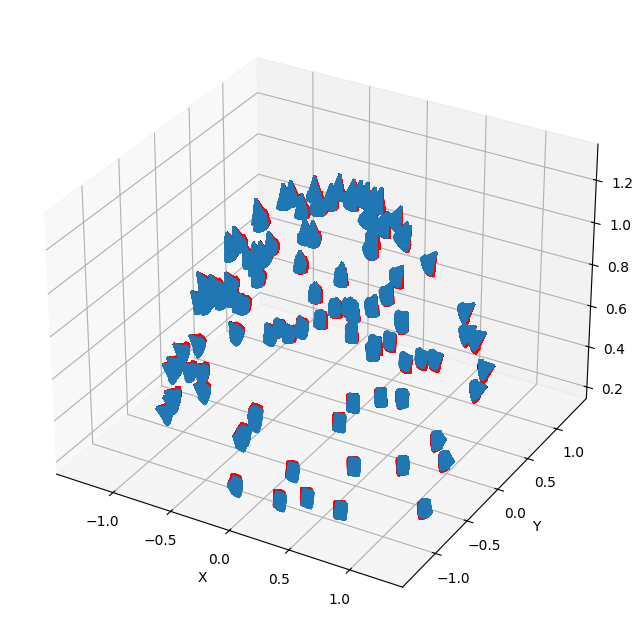

In [61]:
def plot_all_poses(poses, w_R_c_all_perturb, w_T_c_all):


    poses = torch.Tensor(poses).to(device)
    
    w_R_c = poses[:,:3,:3]
    w_T_c = poses[:,:3,3]
    origins = torch.zeros((poses.shape[0],height, width, 3))
    directions = torch.zeros((poses.shape[0],height, width, 3))
    for i in range(poses.shape[0]):
      ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c[i,...].reshape((3,3)), w_T_c[i,...].reshape((3,1)))
      origins[i] = ray_o.to('cpu')
      directions[i] = ray_d.to('cpu')
      
      
    


    ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
    _ = ax.quiver(origins[..., 0].flatten(),
                  origins[..., 1].flatten(),
                  origins[..., 2].flatten(),
                  directions[..., 0].flatten(),
                  directions[..., 1].flatten(),
                  directions[..., 2].flatten(), length=0.12, normalize=True, color='red')
    
    w_R_c = w_R_c_all_perturb
    w_T_c = w_T_c_all
    origins = torch.zeros((poses.shape[0],height, width, 3))
    directions = torch.zeros((poses.shape[0],height, width, 3))
    for i in range(poses.shape[0]):
      ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c[i,...].reshape((3,3)), w_T_c[i,...].reshape((3,1)))
      origins[i] = ray_o.to('cpu')
      directions[i] = ray_d.to('cpu')
      
      
    


    _ = ax.quiver(origins[..., 0].flatten(),
                  origins[..., 1].flatten(),
                  origins[..., 2].flatten(),
                  directions[..., 0].flatten(),
                  directions[..., 1].flatten(),
                  directions[..., 2].flatten(), length=0.12, normalize=True)
  
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('z')
    plt.show()

plot_all_poses(data['poses'], w_R_c_all_perturb, w_T_c_all)

In [73]:
w_R_c_all_perturb.shape

torch.Size([106, 3, 3])

In [74]:

test_pose_w_R_c = test_pose[:3,:3]
test_pose_w_T_c = test_pose[:3, 3]
lr_rotation=0.01

In [75]:
mse_euler_error_list = []
loss_list = []
psnr_list = []

In [76]:
running_mse_euler_error = 0
running_loss = 0
running_psnr = 0

In [ ]:
for i in range(iterations+1):

    
    output_image_idx = np.random.choice(images.shape[0])
    output_image = images[output_image_idx,...]

    w_R_c = w_R_c_all_perturb[output_image_idx,...]
    w_R_c.requires_grad_()
    w_T_c = w_T_c_all[output_image_idx,...]
    
    
    optimizer.zero_grad()
    rec_image = one_forward_pass(height, width, intrinsics, w_R_c, w_T_c, near, far, samples, model, num_x_frequencies, num_d_frequencies)
    w_R_c.retain_grad()
    loss = criterion(rec_image, output_image)
    loss.backward()
    w_R_c_all_perturb[output_image_idx,...] -=  0.1 * w_R_c.grad

    optimizer.step()

    mse_loss_euler = criterion(w_R_c_all, w_R_c_all_perturb)
    running_loss += loss.item()
    psnr = 10 * torch.log10((torch.max(output_image)**2)/loss.item())
    running_psnr += psnr.item()
    running_mse_euler_error += mse_loss_euler.item()

    
    if i % display == 0:
        with torch.no_grad():

            

            test_rec_image = one_forward_pass(height, width, intrinsics, test_pose_w_R_c, test_pose_w_T_c, near, far, samples, model, num_x_frequencies, num_d_frequencies)


            
            loss = criterion(test_rec_image, test_image)
        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
        if i !=0:
            mse_euler_error_list.append(running_mse_euler_error/display)
            loss_list.append(running_loss/display)
            psnr_list.append(running_psnr/display)
            print('The rotation error as compared to GT Rotation :',running_mse_euler_error/display)
            running_mse_euler_error = 0
            running_loss = 0
            running_psnr = 0
        else:
             print('The rotation error as compared to GT Rotation :',running_mse_euler_error)
        if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.1
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(test_rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

plt.imsave('test_lego-perturb-EulerNoise_RMAdditionGrad-lessRot-nerf.png',test_rec_image.detach().cpu().numpy())
torch.save(model.state_dict(),'model_Rperturb-EulerNoise_RMAdditionGrad-nerf-lessRot.pt')
print('Done!')

In [89]:
plt.imsave('test_lego-perturb-EulerNoise_RMAdditionGrad-lessRot-nerf.png',test_rec_image.detach().cpu().numpy())
torch.save(model.state_dict(),'model_Rperturb-EulerNoise_RMAdditionGrad-nerf-lessRot.pt')
print('Done!')

Done!


In [103]:

det_after_train = np.linalg.det(w_R_c_all_perturb.cpu())
print('Mean of the determinants:', det_after_train.mean())
print('Std of the determinants:', det_after_train.std())

Mean of the determinants: 1.0348346
Std of the determinants: 0.03361677


In [83]:
np.save('perturb-EulerNoise_RMAdditionGrad_loss_list_v1-lessRot.npy', np.array(loss_list)[:3000])
np.save('perturb-EulerNoise_RMAdditionGrad_psnr_list_v1-lessRot.npy', np.array(psnr_list)[:3000])
np.save('perturb-EulerNoise_RMAdditionGrad_mse_euler_list_v1-lessRot.npy', np.array(mse_euler_error_list)[1:3000])

In [84]:
loss_list = np.load('perturb-EulerNoise_RMAdditionGrad_loss_list_v1-lessRot.npy')
psnr_list = np.load('perturb-EulerNoise_RMAdditionGrad_psnr_list_v1-lessRot.npy')
mse_euler_error_list = np.load('perturb-EulerNoise_RMAdditionGrad_mse_euler_list_v1-lessRot.npy')

In [ ]:
plt.plot(loss_list)

In [ ]:
plt.plot(psnr_list)

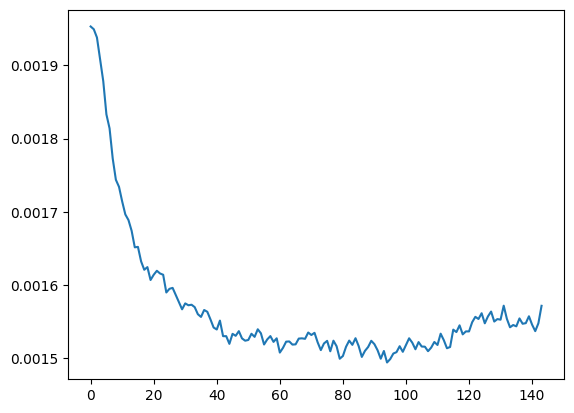

In [87]:
plt.plot(mse_euler_error_list)

In [90]:
model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)
model.load_state_dict(torch.load('model_Rperturb-EulerNoise_RMAdditionGrad-nerf-lessRot.pt'))

<All keys matched successfully>

In [91]:

test_pose_w_R_c = test_pose[:3,:3]
test_pose_w_T_c = test_pose[:3, 3]
lr_rotation=0.1

In [95]:




















test_pose_w_R_c_perturb = rot_d @ test_pose_w_R_c
test_pose_w_R_c, test_pose_w_R_c_perturb.shape,test_pose_w_R_c_perturb

(tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01],
         [-7.2443e-01, -5.0789e-01,  4.6611e-01],
         [ 1.4901e-08, -6.7615e-01, -7.3676e-01]], device='cuda:0'),
 torch.Size([3, 3]),
 tensor([[ 0.7285, -0.5255,  0.4394],
         [-0.6815, -0.4916,  0.5421],
         [-0.0689, -0.6944, -0.7163]], device='cuda:0'))

In [96]:
import copy

In [ ]:

mse_list = []
running_mse = 0
for test_itr in range(3000):
    test_input = copy.deepcopy(test_pose_w_R_c_perturb)
    test_input.requires_grad_()
    

    rec_image = one_forward_pass(height, width, intrinsics, test_input.to(device), test_pose_w_T_c.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_R_c_perturb = test_pose_w_R_c_perturb - lr_rotation * test_input.grad.detach()
     
    mse = criterion(test_pose_w_R_c_perturb.to('cpu'),test_pose_w_R_c.to('cpu')).detach().item()
    running_mse += mse
    if test_itr%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(running_mse/25)
        running_mse = 0
    if test_itr%250==0 and test_itr>0 and test_itr<601:
            lr_rotation *= 0.01

In [ ]:
plt.plot(mse_list[1:])

In [ ]:
np.save('testpose_perturb-EulerNoise_RMAdditionGrad_mse_euler_list_v1-lessRot.npy', np.array(mse_list))

In [ ]:

np.linalg.det(test_pose_w_R_c_perturb)